# Processamento de Linguagem Natural - Trabalho Prático 1
### Thaís Ferreira da Silva - 2021092571

### Objetivo
O objetivo desse trabalho é entender e aplicar conceitos de word embeddings, analisando a qualidade dos modelos treinados em função dos parâmetros escolhidos para o seu treinamento.

### Atividades Principais
Para esse trabalho, utilizei o gensim no treinamento do modelo atraves da variação dos parâmetros do Word2Vec.

Dividi esse trabalho em 4 partes principais:

##### Funções auxiliares: 
Parte contendo todas os métodos implementados para auxiliar no treinamento e avaliação dos modelos.

##### Treinamento: 
Aqui defini os parametros de treinamento e realizei de fato o treinamento dos 54 modelos resultado da variação dos parâmetos: 
- tamanho do vetor de palavras
- tamanho da janela de contexto
- número de interações
- utiliza CBOW ou skip-gram. 

Realizei o treinamento 3 vezes com parâmetros diferentes e armazenei em 3 pastas separadas para futuras analises de desempenho.

##### Avaliação: 
Nessa parte utilizei a distância média do cosseno (metrica exigida pelo trabalho) e a acurácia do modelo para escolher o melhor modelo treinado de acordo com as predições sobre analogias.


### Import

In [1]:
# Imports do gensim - para word2vec
import gensim
from gensim.models import Word2Vec
from gensim.models.word2vec import Text8Corpus

# Imports para graficos
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Imports extras
from scipy.spatial.distance import cosine
import os
import random
import time

-------------------------------------------
## Funções Auxiliares

Optei por desenvolver 4 principais funções com os seguintes objetivos:

- Gerar as combinaçoes de hiperparametros: São 54 variações, onde 3 parâmetros possuem 3 variações, e o for fim temos a variação do skip-gram e CBOW

- Treinar e salvar os modelos: Os modelos são treinados com Word2Vac e para facilitar as analises após o treinamento de cada modelo, eles são salvos em 2 pastas diferentes

- Pegar as analogias: Aqui o arquivo de texto com as analogias são lidos de 4 em 4 palavras e armazenados em um vetor que posteriormente será utilizado para a previsão e avaliação dos modelos

- Avaliar o model: Na avaliação dos modelos, é necessário passar por todas as analogias, e realizar a operação vetorial e prever o 4° elemento do vetor. Dessa forma, ao final de todo o processamento temos os calculos das métricas de avaliação, sendo elas a distância de cosseno e a acurácia.

- Plotar graficos de avaliação: Juntei alguns gráficos que acreditei serem interessantes no mesmo espaço para facilitar as analises futuras.

In [2]:
def generate_hyperparameter_combinations(param_grid):
    from itertools import product
    keys, values = zip(*param_grid.items())
    combinations = [dict(zip(keys, v)) for v in product(*values)]
    return combinations


In [3]:
def train_and_save_model(corpus, params, output_dir):
    model_name = f"word2vec_vs{params['vector_size']}_win{params['window']}_sg{params['sg']}_ep{params['epochs']}"
    print(f"Treinando modelo: {model_name}")
    
    model = Word2Vec(
        sentences=corpus,
        vector_size=params['vector_size'],
        window=params['window'],
        sg=params['sg'],
        epochs=params['epochs'],
        workers=8 #cores do processador
    )
    
    model_path = os.path.join(output_dir, f"{model_name}.model")
    model.save(model_path)
    print(f"Modelo salvo: {model_path}")
    
    return model

In [4]:
def get_analogies(model, questions_words_path):
    final_analogies = []
    with open(questions_words_path, 'r') as f:
        for line in f:
            if line.startswith(':'):
                continue

            words = [word.lower().strip() for word in line.split()]

            final_words = [word for word in words if word in model.wv]
            if len(final_words) != 4:
                continue
            
            final_analogies.append(final_words)
    
    random.shuffle(final_analogies)
    return final_analogies

In [5]:
def new_evaluate_models(model, analogies, model_name):
    avg_distance = 0 
    total_loss = 0 
    correct = 0  
    count = 0  
    results = []  
    start_time = time.time()

    for analogy in analogies:
        if len(analogy) == 4:
            count += 1

            try:
                # Calcula o vetor resultante da analogia
                result_vector = model.wv[analogy[1]] - model.wv[analogy[0]] + model.wv[analogy[2]]

                # Prediz a palavra com base no vetor calculado
                predicted = model.wv.similar_by_vector(result_vector, topn=20, restrict_vocab=None)
                predicted_word = next((word for word, _ in predicted if word not in analogy[:3]), None)

                is_correct = predicted_word == analogy[3]
                if is_correct:
                    correct += 1

                # Calcula a distância cosseno
                if predicted_word in model.wv:
                    cosine_distance = cosine(model.wv[analogy[3]], model.wv[predicted_word])
                    avg_distance += cosine_distance

                # Calcula a loss como a distância cosseno
                if analogy[3] in model.wv:
                    cosine_loss = cosine(model.wv[analogy[3]], result_vector)
                    total_loss += cosine_loss

                # Armazena os detalhes da analogia
                results.append({
                    'sg': 0,
                    'vector_size': 0,
                    'window': 0,
                    'epochs': 0,
                    'analogy': f'{analogy[0]}:{analogy[1]}::{analogy[2]}:{analogy[3]}',
                    'word_a': analogy[0],
                    'word_b': analogy[1],
                    'word_c': analogy[2],
                    'expected_word': analogy[3],
                    'predicted_word': predicted_word,
                    'all_predicted_words': [word for word, _ in predicted], 
                    'correct': is_correct,
                    'accuracy': 0,
                    'avg_distance': 0,
                    'cosine_loss': cosine_loss 
                })

            except KeyError as e:
                print(f"Palavra não encontrada no vocabulário: {e}")

    end_time = time.time()
    execution_time = end_time - start_time

    accuracy = correct / count if count > 0 else 0
    avg_distance = avg_distance / count if count > 0 else 0
    avg_loss = total_loss / count if count > 0 else 0 

    df_results = pd.DataFrame(results)

    return accuracy, avg_distance, avg_loss, df_results

In [6]:
def plot_CBOWxSkipGram(df_final):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    sns.countplot(data=df_final, x='sg', hue='correct', ax=axes[0])
    axes[0].set_title('Número de acertos e erros por tipo de sg')

    sns.scatterplot(data=df_final, x='accuracy', y='avg_distance', hue='sg', ax=axes[1])
    axes[1].set_title('Acurácia x Distância Média')

    plt.tight_layout()
    plt.show()

def plot_embeddings_impact(df_final):
    #impacto do tamanho do embedding no valor da acurácia e da distância média
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    sns.scatterplot(data=df_final, x='vector_size', y='accuracy', hue='sg', ax=axes[0])
    axes[0].set_title('Tamanho do Embedding x Acurácia')

    sns.scatterplot(data=df_final, x='vector_size', y='avg_distance', hue='sg', ax=axes[1])
    axes[1].set_title('Tamanho do Embedding x Distância Média')

    plt.tight_layout()
    plt.show()

    # Boxplot (Distribuição das Distâncias)
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    sns.boxplot(data=df_final, x='sg', y='avg_distance', ax=axes[0])
    axes[0].set_title('Distribuição das Distâncias por SG')

    sns.boxplot(data=df_final, x='sg', y='accuracy', ax=axes[1])
    axes[1].set_title('Distribuição das Acurácias por SG')

    plt.tight_layout()
    plt.show()


def plot_epochs(df_final):
    # Boxplot (Impacto do Número de Épocas na Acurácia)
    fig, ax = plt.subplots(figsize=(15, 6))

    sns.boxplot(data=df_final, x='epochs', y='accuracy', hue='sg', ax=ax)
    ax.set_title('Impacto do Número de Épocas na Acurácia')
    ax.set_ylabel('Acurácia')
    ax.set_xlabel('Número de Épocas')

    plt.tight_layout()
    plt.show()
    

    #Gráfico de Linhas (Evolução da Acurácia e Distância Média)
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    sns.lineplot(data=df_final, x='epochs', y='accuracy', hue='sg', ax=axes[0])
    axes[0].set_title('Evolução da Acurácia por Época')

    sns.lineplot(data=df_final, x='epochs', y='avg_distance', hue='sg', ax=axes[1])
    axes[1].set_title('Evolução da Distância Média por Época')

    plt.tight_layout()
    plt.show()


-------------------------------------------
## Inicialização
Aqui definimos lemos o arquivo do courpus, e definimos as pastas onde os modelos serão armazenados futuramente

In [7]:
text8_path = './text8'
corpus = Text8Corpus(text8_path)

sentence = next(iter(corpus))
print(sentence[:15])

output_dir = './word2vec_models'
os.makedirs(output_dir, exist_ok=True)

output_dir1 = './word2vec_models_v1'
os.makedirs(output_dir1, exist_ok=True)

output_dir2 = './word2vec_models_v2'
os.makedirs(output_dir2, exist_ok=True)

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including']


-------------------------------------------
# Treinamento dos modelos Word2Vec

In [189]:
# Hiperparâmetros para o GridSearch
param_grid = {
    'vector_size': [50, 100, 200],      # Tamanho do vetor de palavras
    'window': [3, 5, 7],                # Tamanho da janela de contexto
    'sg': [0, 1],                      # CBOW (0) ou Skip-gram (1)
    'epochs': [5, 10, 15],             # Número de iterações de treinamento
}

combinations = generate_hyperparameter_combinations(param_grid)

for i, params in enumerate(combinations):
    print(f"\nTreinando combinação {i+1}/{len(combinations)}: {params}")
    model = train_and_save_model(corpus, params, output_dir)


Treinando combinação 1/54: {'vector_size': 50, 'window': 3, 'sg': 0, 'epochs': 5}
Treinando modelo: word2vec_vs50_win3_sg0_ep5
Modelo salvo: ./word2vec_models/word2vec_vs50_win3_sg0_ep5.model

Treinando combinação 2/54: {'vector_size': 50, 'window': 3, 'sg': 0, 'epochs': 10}
Treinando modelo: word2vec_vs50_win3_sg0_ep10
Modelo salvo: ./word2vec_models/word2vec_vs50_win3_sg0_ep10.model

Treinando combinação 3/54: {'vector_size': 50, 'window': 3, 'sg': 0, 'epochs': 15}
Treinando modelo: word2vec_vs50_win3_sg0_ep15
Modelo salvo: ./word2vec_models/word2vec_vs50_win3_sg0_ep15.model

Treinando combinação 4/54: {'vector_size': 50, 'window': 3, 'sg': 1, 'epochs': 5}
Treinando modelo: word2vec_vs50_win3_sg1_ep5
Modelo salvo: ./word2vec_models/word2vec_vs50_win3_sg1_ep5.model

Treinando combinação 5/54: {'vector_size': 50, 'window': 3, 'sg': 1, 'epochs': 10}
Treinando modelo: word2vec_vs50_win3_sg1_ep10
Modelo salvo: ./word2vec_models/word2vec_vs50_win3_sg1_ep10.model

Treinando combinação 6/54

In [190]:
# Hiperparâmetros para o GridSearch
param_grid1 = {
    'vector_size': [150, 250, 300],      # Tamanho do vetor de palavras
    'window': [3, 5, 7],                # Tamanho da janela de contexto
    'sg': [0, 1],                      # CBOW (0) ou Skip-gram (1)
    'epochs': [5, 10, 15],             # Número de iterações de treinamento
}

combinations1 = generate_hyperparameter_combinations(param_grid1)

for j, params in enumerate(combinations1):
    print(f"\nTreinando combinação {j+1}/{len(combinations1)}: {params}")
    model1 = train_and_save_model(corpus, params, output_dir1)


Treinando combinação 1/54: {'vector_size': 150, 'window': 3, 'sg': 0, 'epochs': 5}
Treinando modelo: word2vec_vs150_win3_sg0_ep5
Modelo salvo: ./word2vec_models_v1/word2vec_vs150_win3_sg0_ep5.model

Treinando combinação 2/54: {'vector_size': 150, 'window': 3, 'sg': 0, 'epochs': 10}
Treinando modelo: word2vec_vs150_win3_sg0_ep10
Modelo salvo: ./word2vec_models_v1/word2vec_vs150_win3_sg0_ep10.model

Treinando combinação 3/54: {'vector_size': 150, 'window': 3, 'sg': 0, 'epochs': 15}
Treinando modelo: word2vec_vs150_win3_sg0_ep15
Modelo salvo: ./word2vec_models_v1/word2vec_vs150_win3_sg0_ep15.model

Treinando combinação 4/54: {'vector_size': 150, 'window': 3, 'sg': 1, 'epochs': 5}
Treinando modelo: word2vec_vs150_win3_sg1_ep5
Modelo salvo: ./word2vec_models_v1/word2vec_vs150_win3_sg1_ep5.model

Treinando combinação 5/54: {'vector_size': 150, 'window': 3, 'sg': 1, 'epochs': 10}
Treinando modelo: word2vec_vs150_win3_sg1_ep10
Modelo salvo: ./word2vec_models_v1/word2vec_vs150_win3_sg1_ep10.mo

In [9]:
# Hiperparâmetros para o GridSearch
param_grid2 = {
    'vector_size': [50, 100, 200],      # Tamanho do vetor de palavras
    'window': [3, 5, 7],                # Tamanho da janela de contexto
    'sg': [0, 1],                      # CBOW (0) ou Skip-gram (1)
    'epochs': [20, 25, 30],             # Número de iterações de treinamento
}

combinations2 = generate_hyperparameter_combinations(param_grid2)

for j, params in enumerate(combinations2):
    print(f"\nTreinando combinação {j+1}/{len(combinations2)}: {params}")
    model2 = train_and_save_model(corpus, params, output_dir2)


Treinando combinação 1/54: {'vector_size': 50, 'window': 3, 'sg': 0, 'epochs': 20}
Treinando modelo: word2vec_vs50_win3_sg0_ep20
Modelo salvo: ./word2vec_models_v2/word2vec_vs50_win3_sg0_ep20.model

Treinando combinação 2/54: {'vector_size': 50, 'window': 3, 'sg': 0, 'epochs': 25}
Treinando modelo: word2vec_vs50_win3_sg0_ep25
Modelo salvo: ./word2vec_models_v2/word2vec_vs50_win3_sg0_ep25.model

Treinando combinação 3/54: {'vector_size': 50, 'window': 3, 'sg': 0, 'epochs': 30}
Treinando modelo: word2vec_vs50_win3_sg0_ep30
Modelo salvo: ./word2vec_models_v2/word2vec_vs50_win3_sg0_ep30.model

Treinando combinação 4/54: {'vector_size': 50, 'window': 3, 'sg': 1, 'epochs': 20}
Treinando modelo: word2vec_vs50_win3_sg1_ep20
Modelo salvo: ./word2vec_models_v2/word2vec_vs50_win3_sg1_ep20.model

Treinando combinação 5/54: {'vector_size': 50, 'window': 3, 'sg': 1, 'epochs': 25}
Treinando modelo: word2vec_vs50_win3_sg1_ep25
Modelo salvo: ./word2vec_models_v2/word2vec_vs50_win3_sg1_ep25.model

Trei

-------------------------------------------
## Avaliação dos modelos
### Modelo base

In [9]:
questions_words_path = './questions-words.txt'

models = os.listdir(output_dir)
models = [model for model in models if model.endswith('.model')]

model_metrics = []
all_results = []

num_modelo = 0

for model_name in models:
    num_modelo += 1
    model = Word2Vec.load(os.path.join(output_dir, model_name))
    analogies = get_analogies(model, questions_words_path)
    accuracy, avg_distance, avg_loss, df_results = new_evaluate_models(model, analogies, model_name)
    
    print(f"Modelo: [{num_modelo}]", end='\r')
    
    model_metrics.append({
        'model_name': model_name,
        'accuracy': accuracy,
        'avg_distance': avg_distance,
        'vector_size': model.vector_size,
        'window': model.window,
        'sg': model.sg,
        'epochs': model.epochs
    })

    df_results['sg'] = 'CBOW' if model.sg == 0 else 'SkipGram'
    df_results['vector_size'] = model.vector_size
    df_results['window'] = model.window
    df_results['epochs'] = model.epochs

    df_results['accuracy'] = accuracy
    df_results['avg_distance'] = avg_distance
    df_results['avg_loss'] = avg_loss
        
    all_results.append(df_results)

final_df = pd.concat(all_results, ignore_index=True)

final_df.to_csv('./results/results.csv', index=False)

In [10]:
df = pd.read_csv('./results/results.csv')
df.head()

,sg,vector_size,window,epochs,analogy,word_a,word_b,word_c,expected_word,predicted_word,all_predicted_words,correct,accuracy,avg_distance,cosine_loss,avg_loss
0,CBOW,50,3,15,dollar:dollars::donkey:donkeys,dollar,dollars,donkey,donkeys,folks,"['folks', 'insects', 'annelids', 'cyborgs', 'r...",False,0.198519,0.371314,0.636750,0.4211
1,CBOW,50,3,15,brazil:real::algeria:dinar,brazil,real,algeria,dinar,irrational,"['real', 'irrational', 'continuous', 'rational...",False,0.198519,0.371314,0.970952,0.4211
2,CBOW,50,3,15,libreville:gabon::roseau:dominica,libreville,gabon,roseau,dominica,botswana,"['gabon', 'botswana', 'kyrgyzstan', 'liberia',...",False,0.198519,0.371314,0.290470,0.4211
3,CBOW,50,3,15,work:works::sit:sits,work,works,sit,sits,desks,"['sit', 'desks', 'sat', 'kneel', 'recited', 's...",False,0.198519,0.371314,0.546503,0.4211
4,CBOW,50,3,15,lisbon:portugal::managua:nicaragua,lisbon,portugal,managua,nicaragua,asturias,"['portugal', 'asturias', 'afonso', 'castile', ...",False,0.198519,0.371314,0.480596,0.4211


### Modelo 1

In [ ]:
questions_words_path = './questions-words.txt'

models1 = os.listdir(output_dir1)
models1 = [model1 for model1 in models1 if model1.endswith('.model')]

model_metrics1 = []
all_results1 = []

num_modelo1 = 0

for model_name1 in models1:
    num_modelo1 +=1
    model1 = Word2Vec.load(os.path.join(output_dir1, model_name1))
    analogies1 = get_analogies(model1, questions_words_path)
    accuracy1, avg_distance1, avg_loss1, df_results1 = new_evaluate_models(model1, analogies1, model_name1)
    
    print(f"Modelo: [{num_modelo1}]", end='\r')
    
    model_metrics1.append({
        'model_name': model_name1,
        'accuracy': accuracy1,
        'avg_distance': avg_distance1,
        'vector_size': model1.vector_size,
        'window': model1.window,
        'sg': model1.sg,
        'epochs': model1.epochs
    })

    df_results1['sg'] = 'CBOW' if model1.sg == 0 else 'SkipGram'
    df_results1['vector_size'] = model1.vector_size
    df_results1['window'] = model1.window
    df_results1['epochs'] = model1.epochs

    df_results1['accuracy'] = accuracy1
    df_results1['avg_distance'] = avg_distance1
    df_results1['avg_loss'] = avg_loss1
        
    all_results1.append(df_results1)

final_df1 = pd.concat(all_results1, ignore_index=True)

final_df1.to_csv('./results/results1.csv', index=False)

In [11]:
df1 = pd.read_csv('./results/results1.csv')
df1.head()

,sg,vector_size,window,epochs,analogy,word_a,word_b,word_c,expected_word,predicted_word,all_predicted_words,correct,accuracy,avg_distance,cosine_loss,avg_loss
0,CBOW,250,7,10,nuuk:greenland::suva:fiji,nuuk,greenland,suva,fiji,iceland,"['greenland', 'iceland', 'antarctica', 'domini...",False,0.255175,0.447041,0.477899,0.551813
1,CBOW,250,7,10,sons:daughters::brother:sister,sons,daughters,brother,sister,sister,"['brother', 'sister', 'aunt', 'niece', 'siblin...",True,0.255175,0.447041,0.353538,0.551813
2,CBOW,250,7,10,hand:hands::pineapple:pineapples,hand,hands,pineapple,pineapples,shelled,"['hands', 'shelled', 'disbanded', 'townsfolk',...",False,0.255175,0.447041,0.857754,0.551813
3,CBOW,250,7,10,ljubljana:slovenia::nouakchott:mauritania,ljubljana,slovenia,nouakchott,mauritania,slovakia,"['slovenia', 'slovakia', 'croatia', 'romania',...",False,0.255175,0.447041,0.418239,0.551813
4,CBOW,250,7,10,tampa:florida::plano:texas,tampa,florida,plano,texas,california,"['florida', 'california', 'iowa', 'nebraska', ...",False,0.255175,0.447041,0.529912,0.551813


### Modelo 2

In [ ]:
questions_words_path = './questions-words.txt'

models2 = os.listdir(output_dir2)
models2 = [model2 for model2 in models2 if model2.endswith('.model')]

model_metrics2 = []
all_results2 = []

num_modelo2 = 0

for model_name2 in models2:
    num_modelo2 +=1
    model2 = Word2Vec.load(os.path.join(output_dir2, model_name2))
    analogies2 = get_analogies(model2, questions_words_path)
    accuracy2, avg_distance2, avg_loss2, df_results2 = new_evaluate_models(model2, analogies2, model_name2)
    
    print(f"Modelo: [{num_modelo2}]", end='\r')
    
    model_metrics2.append({
        'model_name': model_name2,
        'accuracy': accuracy2,
        'avg_distance': avg_distance2,
        'vector_size': model2.vector_size,
        'window': model2.window,
        'sg': model2.sg,
        'epochs': model2.epochs
    })

    df_results2['sg'] = 'CBOW' if model2.sg == 0 else 'SkipGram'
    df_results2['vector_size'] = model2.vector_size
    df_results2['window'] = model2.window
    df_results2['epochs'] = model2.epochs

    df_results2['accuracy'] = accuracy2
    df_results2['avg_distance'] = avg_distance2
    df_results2['avg_loss'] = avg_loss2
        
    all_results2.append(df_results2)

final_df2 = pd.concat(all_results2, ignore_index=True)

final_df2.to_csv('./results/results2.csv', index=False)

In [12]:
df2 = pd.read_csv('./results/results2.csv')
df2.head()

,sg,vector_size,window,epochs,analogy,word_a,word_b,word_c,expected_word,predicted_word,all_predicted_words,correct,accuracy,avg_distance,cosine_loss,avg_loss
0,CBOW,50,7,25,nouakchott:mauritania::rabat:morocco,nouakchott,mauritania,rabat,morocco,mali,"['mauritania', 'mali', 'sahara', 'djibouti', '...",False,0.230044,0.385117,0.239418,0.422301
1,CBOW,50,7,25,mexico:mexican::norway:norwegian,mexico,mexican,norway,norwegian,swedish,"['swedish', 'norway', 'norwegian', 'danish', '...",False,0.230044,0.385117,0.308278,0.422301
2,CBOW,50,7,25,convenient:inconvenient::certain:uncertain,convenient,inconvenient,certain,uncertain,various,"['certain', 'various', 'these', 'some', 'contr...",False,0.230044,0.385117,0.910631,0.422301
3,CBOW,50,7,25,algeria:dinar::poland:zloty,algeria,dinar,poland,zloty,hungary,"['poland', 'hungary', 'kazimierz', 'lotharingi...",False,0.230044,0.385117,0.467407,0.422301
4,CBOW,50,7,25,dallas:texas::boston:massachusetts,dallas,texas,boston,massachusetts,massachusetts,"['boston', 'massachusetts', 'pennsylvania', 's...",True,0.230044,0.385117,0.192123,0.422301


In [14]:
df_final = pd.concat([df, df1, df2], ignore_index=True)
df_final.to_csv('./results/results_final.csv', index=False)

In [8]:
#top 10 dos melhores modelos de acordo com a distancia media
#como o computador estava dando problema no kernel, foi necessario ler de novo do arquivo para rodar as celulas abaixo
df_analise = pd.read_csv('./results/results_final.csv')
df_analise.sort_values(by='avg_distance').head(5)


,sg,vector_size,window,epochs,analogy,word_a,word_b,word_c,expected_word,predicted_word,all_predicted_words,correct,accuracy,avg_distance,cosine_loss,avg_loss
837770,SkipGram,50,3,5,tirana:albania::warsaw:poland,tirana,albania,warsaw,poland,bulgaria,"['warsaw', 'albania', 'bulgaria', 'poland', 'c...",False,0.196948,0.236293,0.162804,0.305413
837707,SkipGram,50,3,5,oslo:norway::santiago:chile,oslo,norway,santiago,chile,rosario,"['santiago', 'rosario', 'veracruz', 'punta', '...",False,0.196948,0.236293,0.358415,0.305413
837708,SkipGram,50,3,5,wide:widest::fast:fastest,wide,widest,fast,fastest,midpoint,"['fast', 'midpoint', 'slowest', 'quickest', 's...",False,0.196948,0.236293,0.417067,0.305413
837709,SkipGram,50,3,5,describe:describing::look:looking,describe,describing,look,looking,looking,"['look', 'looking', 'looks', 'glance', 'walks'...",True,0.196948,0.236293,0.253621,0.305413
837710,SkipGram,50,3,5,going:went::implementing:implemented,going,went,implementing,implemented,lobbying,"['implementing', 'lobbying', 'restructuring', ...",False,0.196948,0.236293,0.356570,0.305413


In [9]:
#top 10 dos melhores modelos de acordo com a acuracia
df_analise.sort_values(by='accuracy', ascending=False).head(5)

,sg,vector_size,window,epochs,analogy,word_a,word_b,word_c,expected_word,predicted_word,all_predicted_words,correct,accuracy,avg_distance,cosine_loss,avg_loss
499147,SkipGram,200,7,15,tashkent:uzbekistan::tripoli:libya,tashkent,uzbekistan,tripoli,libya,benghazi,"['uzbekistan', 'tripoli', 'benghazi', 'turkmen...",False,0.357267,0.365595,0.523485,0.546137
481334,SkipGram,200,7,15,anchorage:alaska::memphis:tennessee,anchorage,alaska,memphis,tennessee,tennessee,"['memphis', 'tennessee', 'arkansas', 'mississi...",True,0.357267,0.365595,0.487305,0.546137
481340,SkipGram,200,7,15,riga:latvia::tehran:iran,riga,latvia,tehran,iran,libya,"['tehran', 'latvia', 'libya', 'iran', 'lebanon...",False,0.357267,0.365595,0.501019,0.546137
481342,SkipGram,200,7,15,baku:azerbaijan::hanoi:vietnam,baku,azerbaijan,hanoi,vietnam,karabakh,"['azerbaijan', 'hanoi', 'karabakh', 'armenia',...",False,0.357267,0.365595,0.628256,0.546137
481348,SkipGram,200,7,15,amarillo:texas::huntsville:alabama,amarillo,texas,huntsville,alabama,kansas,"['texas', 'huntsville', 'kansas', 'florida', '...",False,0.357267,0.365595,0.432175,0.546137


-----------------------------
## Analise dos resultados
### Impacto da arquitetura: CBOW (Continuous Bag of Words) x Skip-gram

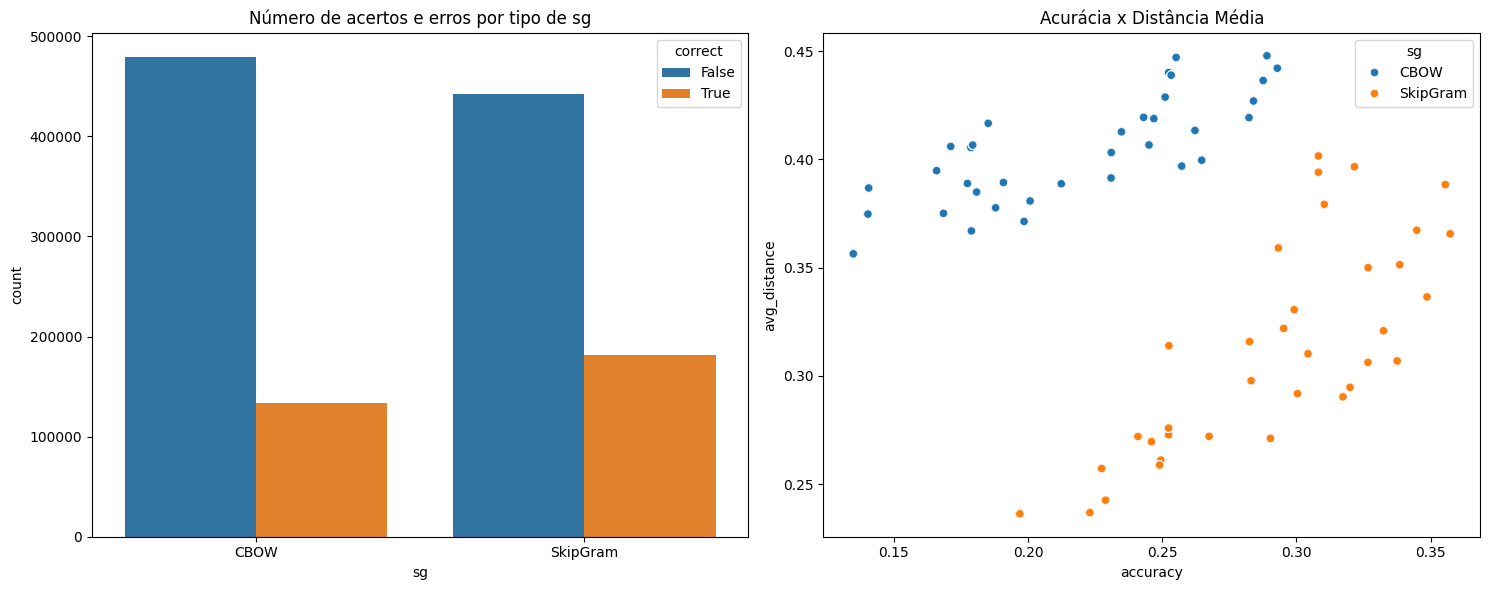

In [10]:
plot_CBOWxSkipGram(df_analise)

Através dessa analise inicial, podemos concluir que ambos os modelos não foram muito precisos, falhando na tarefa de predição em quase todos os casos e obtendo uma acurácia máxima de 0.35.

Se faz importante ressaltar que optei por utilizar duas métricas diferentes para avaliação dos modelos. O demandado para o trabalho foi a utilização da distância de cosseno para a tarefa de avaliação, no entanto o melhor modelo apontado por essa métrica não era muito preciso. Por esse motivo, adicionei a medição da acurácia, o qual apontou outro modelo como sendo o melhor.

Melhores modelos:
- Distância: SkipGram +	50 embedding + 3 window + 5 epochs -> acurácia +- = 0.19 -> distancia +- = 0.23
- Acurácia: SkipGram + 200 embedding + 7 window + 15 epochs -> acurácia +- = 0.35 -> distancia +- = 0.36

Para todos os casos analisados, fica claro a superioridade do algoritmo Skip-gram em relação do CBOW, alcançando maiores acurácias e menores distâncias. Isso pode ser observado pelos dois gráficos acima, onde vemos no grafico de barras que o Skip-gram acertou mais vezes, e no grafico de pontos as métricas apontam que os valores de acurácia e distância média foram melhores para o Skip-gram com valores mais abaixos e para a direita.

Uma incógnita que fica em relação as métricas encontrada é o motivo da distância de cosseno ser tão alta para modelos com resultados melhores. O que eu acredito que possa motivar essa anomalia é o tamanho pequeno do corpus já que o resultado esperado é diferente.

### Impacto do tamanho do embedding / vector_size - acurácia x distância de cosseno

/tmp/ipykernel_39457/3750459018.py:23: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


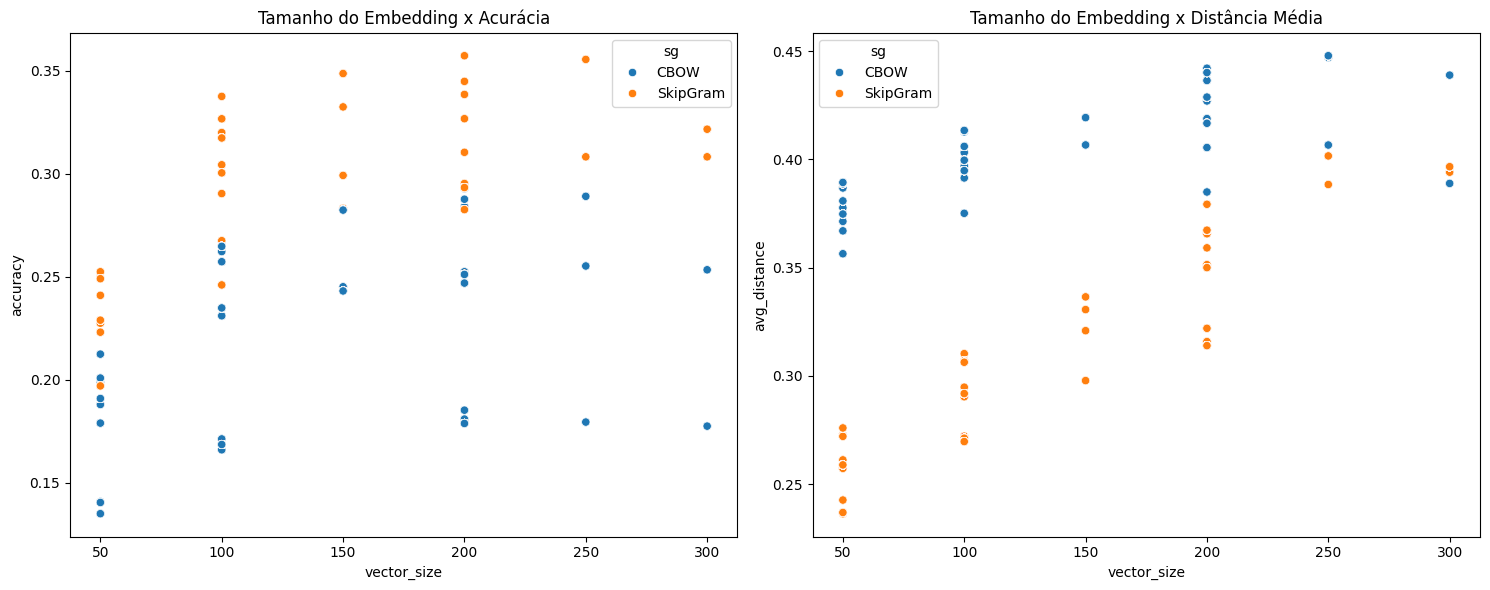

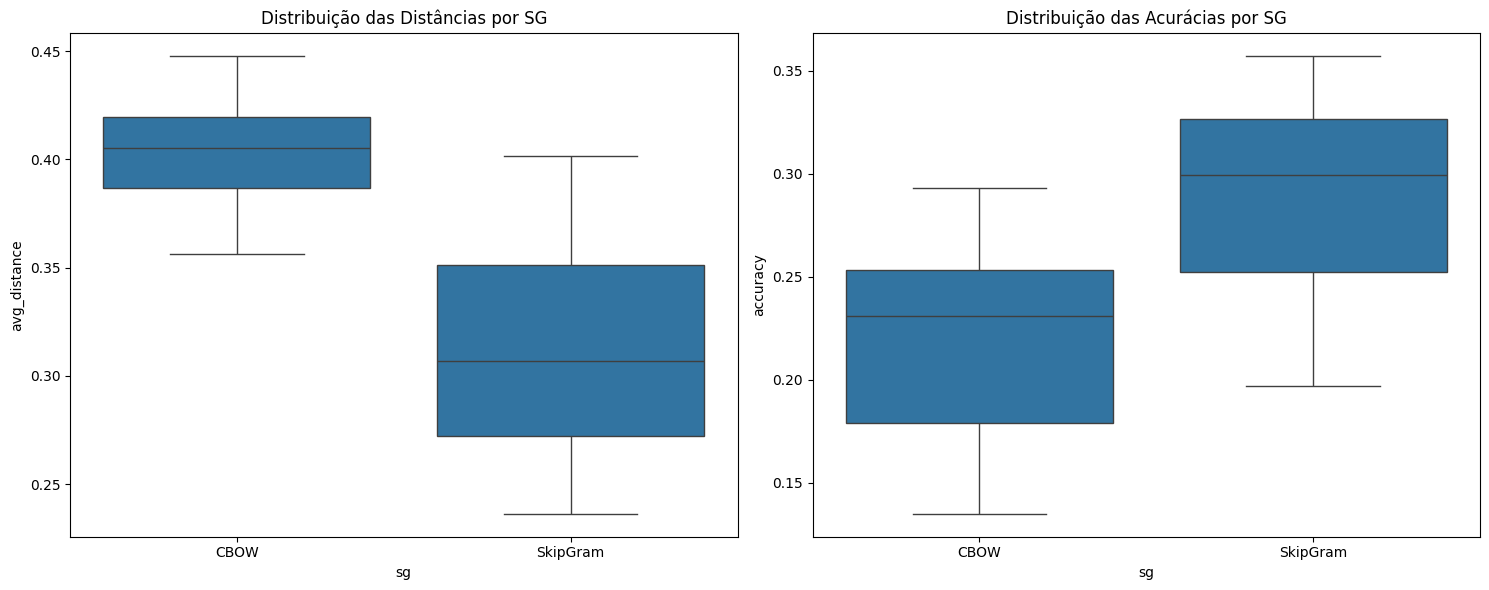

In [10]:
plot_embeddings_impact(df_analise)

Um ponto interessante a se analisar é o impacto do embedding no resultado obtido para ambas as métricas. 
Para esse caso, fica claro que quanto maior o tamanho do embedding, maior é o valora da acurácia, e menor é a distância média associada, o que sugere que embeddings maiores resultam em melhores representações. 

Também pude perceber que parece que os resultados estão chegando num certo limite de crescimento, o que pode indicar que aumentar muito maios o valor do embedding pode não necessariamente melhorar o desempenho de forma significativa. Através do primeiro gráfico podemos perceber que os valores de acurácia não melhoram muito mais após 200 de embedding, e que temos uma leve queda do seu valor com 300 de tamanho.

### Impacto da quantidade de épocas - Overfitting

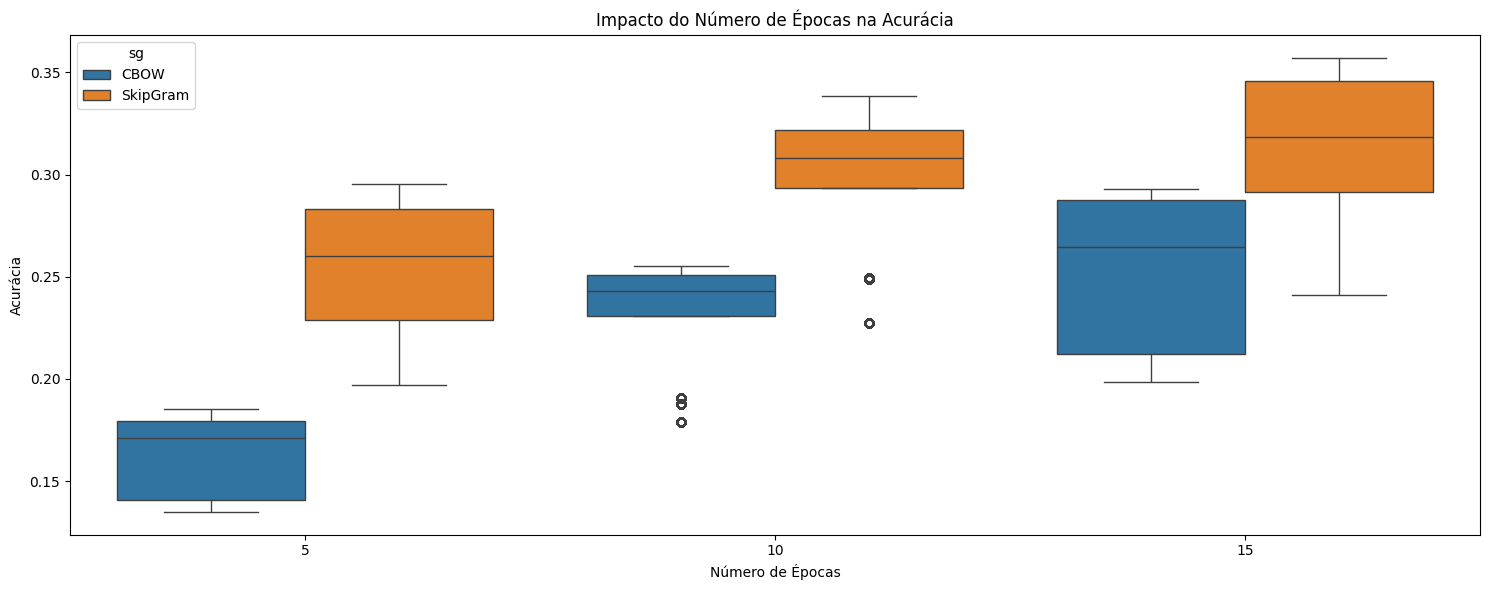

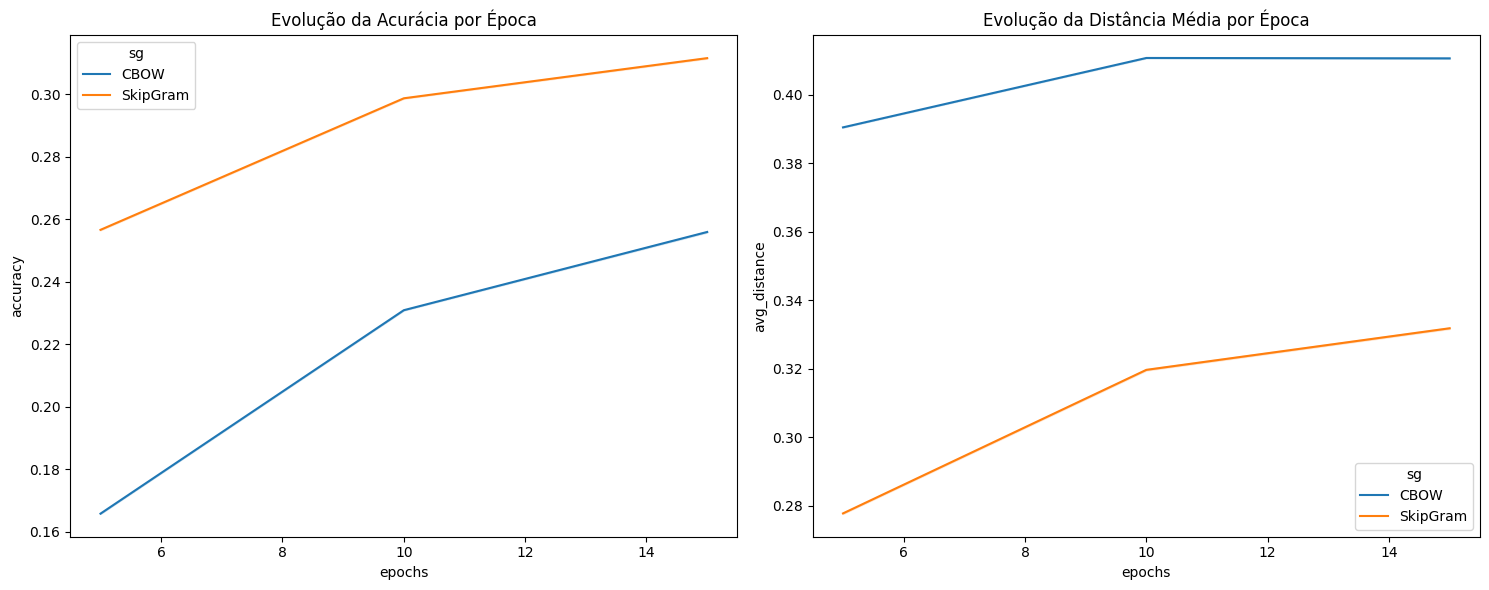

In [11]:
plot_epochs(df_analise)

Uma outra analise que achei relevante de comentar é o impacto da quantidade de épocas no desempenho do algoritmo.

A tendência geral é que a acurácia aumente à medida que o número de épocas cresça para ambos os modelos, sugerindo que mais épocas contribuem para um melhor aprendizado.

Atraves do bootstrap de épocas por acurácia, podemos perceber que o SkipGram apresenta menos variabilidade (intervalos menores) nas acurácias conforme as épocas aumentam, indicando que o desempenho é mais estável. Já o CBOW, em comparação, tem distribuições mais amplas, especialmente com 15 épocas, o que pode indicar maior variabilidade nos resultados.

Ambos os modelos beneficiam-se de treinos mais longos (maior número de épocas), resultando em maior acurácia.

### Melhor modelo obtido:
SkipGram + 200 embedding + 7 window + 15 epochs -> acurácia +- = 0.35 -> distancia +- = 0.36